In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

#!pip install --upgrade pip
#!pip install scikit-image xmltodict
#!pip install onnxruntime-gpu

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/train_czann')

import tempfile
from tools import _extract_model
import json
from pathlib import Path
from tools._onnx_inference import OnnxInferencer
import onnxruntime as onnx_rt

# Define the parameters for loading the training data

# adjust to jour needs
base_directory = r"/content/gdrive/MyDrive/Colab Notebooks/train_czann"

# place the original and label *.png images here
imgfolder = "nucleus_data/images/"

# masks images have one channel (0=background and 1=object)
maskfolder = 'nucleus_data/label/'

modelfolder = "trained_models"

# construct the final path to the images and labels
IMAGES_FOLDER = os.path.join(base_directory, imgfolder)
MASKS_FOLDER = os.path.join(base_directory, maskfolder)

# get the sample images
sample_images = sorted([os.path.join(IMAGES_FOLDER, f) for f in os.listdir(IMAGES_FOLDER)
                        if os.path.isfile(os.path.join(IMAGES_FOLDER, f))])

# get the maks
sample_masks = sorted([os.path.join(MASKS_FOLDER, f) for f in os.listdir(MASKS_FOLDER)
                       if os.path.isfile(os.path.join(MASKS_FOLDER, f))])

czann_file = os.path.join(os.path.join(base_directory, modelfolder), "simple_nuclei_segmodel.czann")
czseg_file = os.path.join(os.path.join(base_directory, modelfolder), "simple_nuclei_segmodel_legacy.czseg")

In [ ]:
def predict_one(sess, array2d):

            array2d = array2d[np.newaxis]
            input_name = sess.get_inputs()[0].name
            output_name = sess.get_outputs()[0].name

            # ONNX can only handle float32
            array2d = array2d.astype(np.float32)
            input_dict = {input_name: array2d}
            result = sess.run([output_name], input_dict)[0]

            return result[0]

In [ ]:
from skimage import io
import random

# select an random image
id = random.randint(0, len(sample_images))

# extract the model information and path and to the prediction
with tempfile.TemporaryDirectory() as temp_path:

    # get the model metadata and the path
    model_metadata, model_path = _extract_model.extract_model(czann_file, Path(temp_path))

    # create an ONNX session and get the input shape
    sess = onnx_rt.InferenceSession(str(model_path), providers=["CUDAExecutionProvider"])
    input_shape = sess.get_inputs()[0].shape

    # read images and scale
    img = io.imread(sample_images[id])/(2**16 - 1)
    mask = io.imread(sample_masks[id])

    # cut input to fit the model
    img = img[0: input_shape[1], 0:input_shape[2]]
    mask = mask[0: input_shape[1], 0:input_shape[2]]
    print(img.shape, type(img), img.dtype)

    # run the prediction
    pred = predict_one(sess, img[..., np.newaxis])

> Loading JSON from '/tmp/tmpfylfl_40/model.json'
(1024, 1024) <class 'numpy.ndarray'> float64


Text(0.5, 1.0, 'Label Mask')

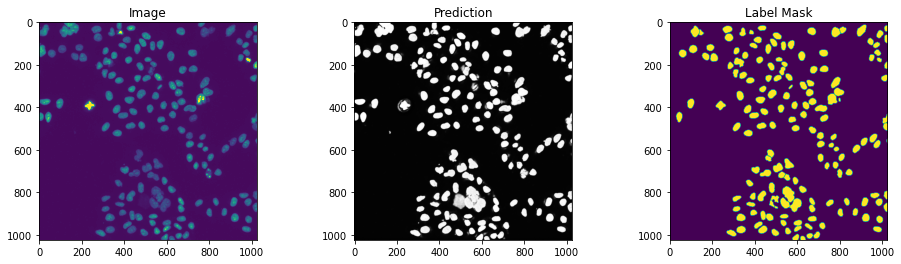

In [ ]:
# scale the image and show the results
#img_scaled = img / img.max()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(16)

# show images and set titles
ax1.imshow(img, vmin=0, vmax=0.05)
ax2.imshow(pred[..., 1], cmap="gray")
ax3.imshow(mask)

ax1.set_title('Image')
ax2.set_title('Prediction')
ax3.set_title('Label Mask')